# Experiments

It means that running your application over a dataset and evaluating performance

Creating the 1st experiment

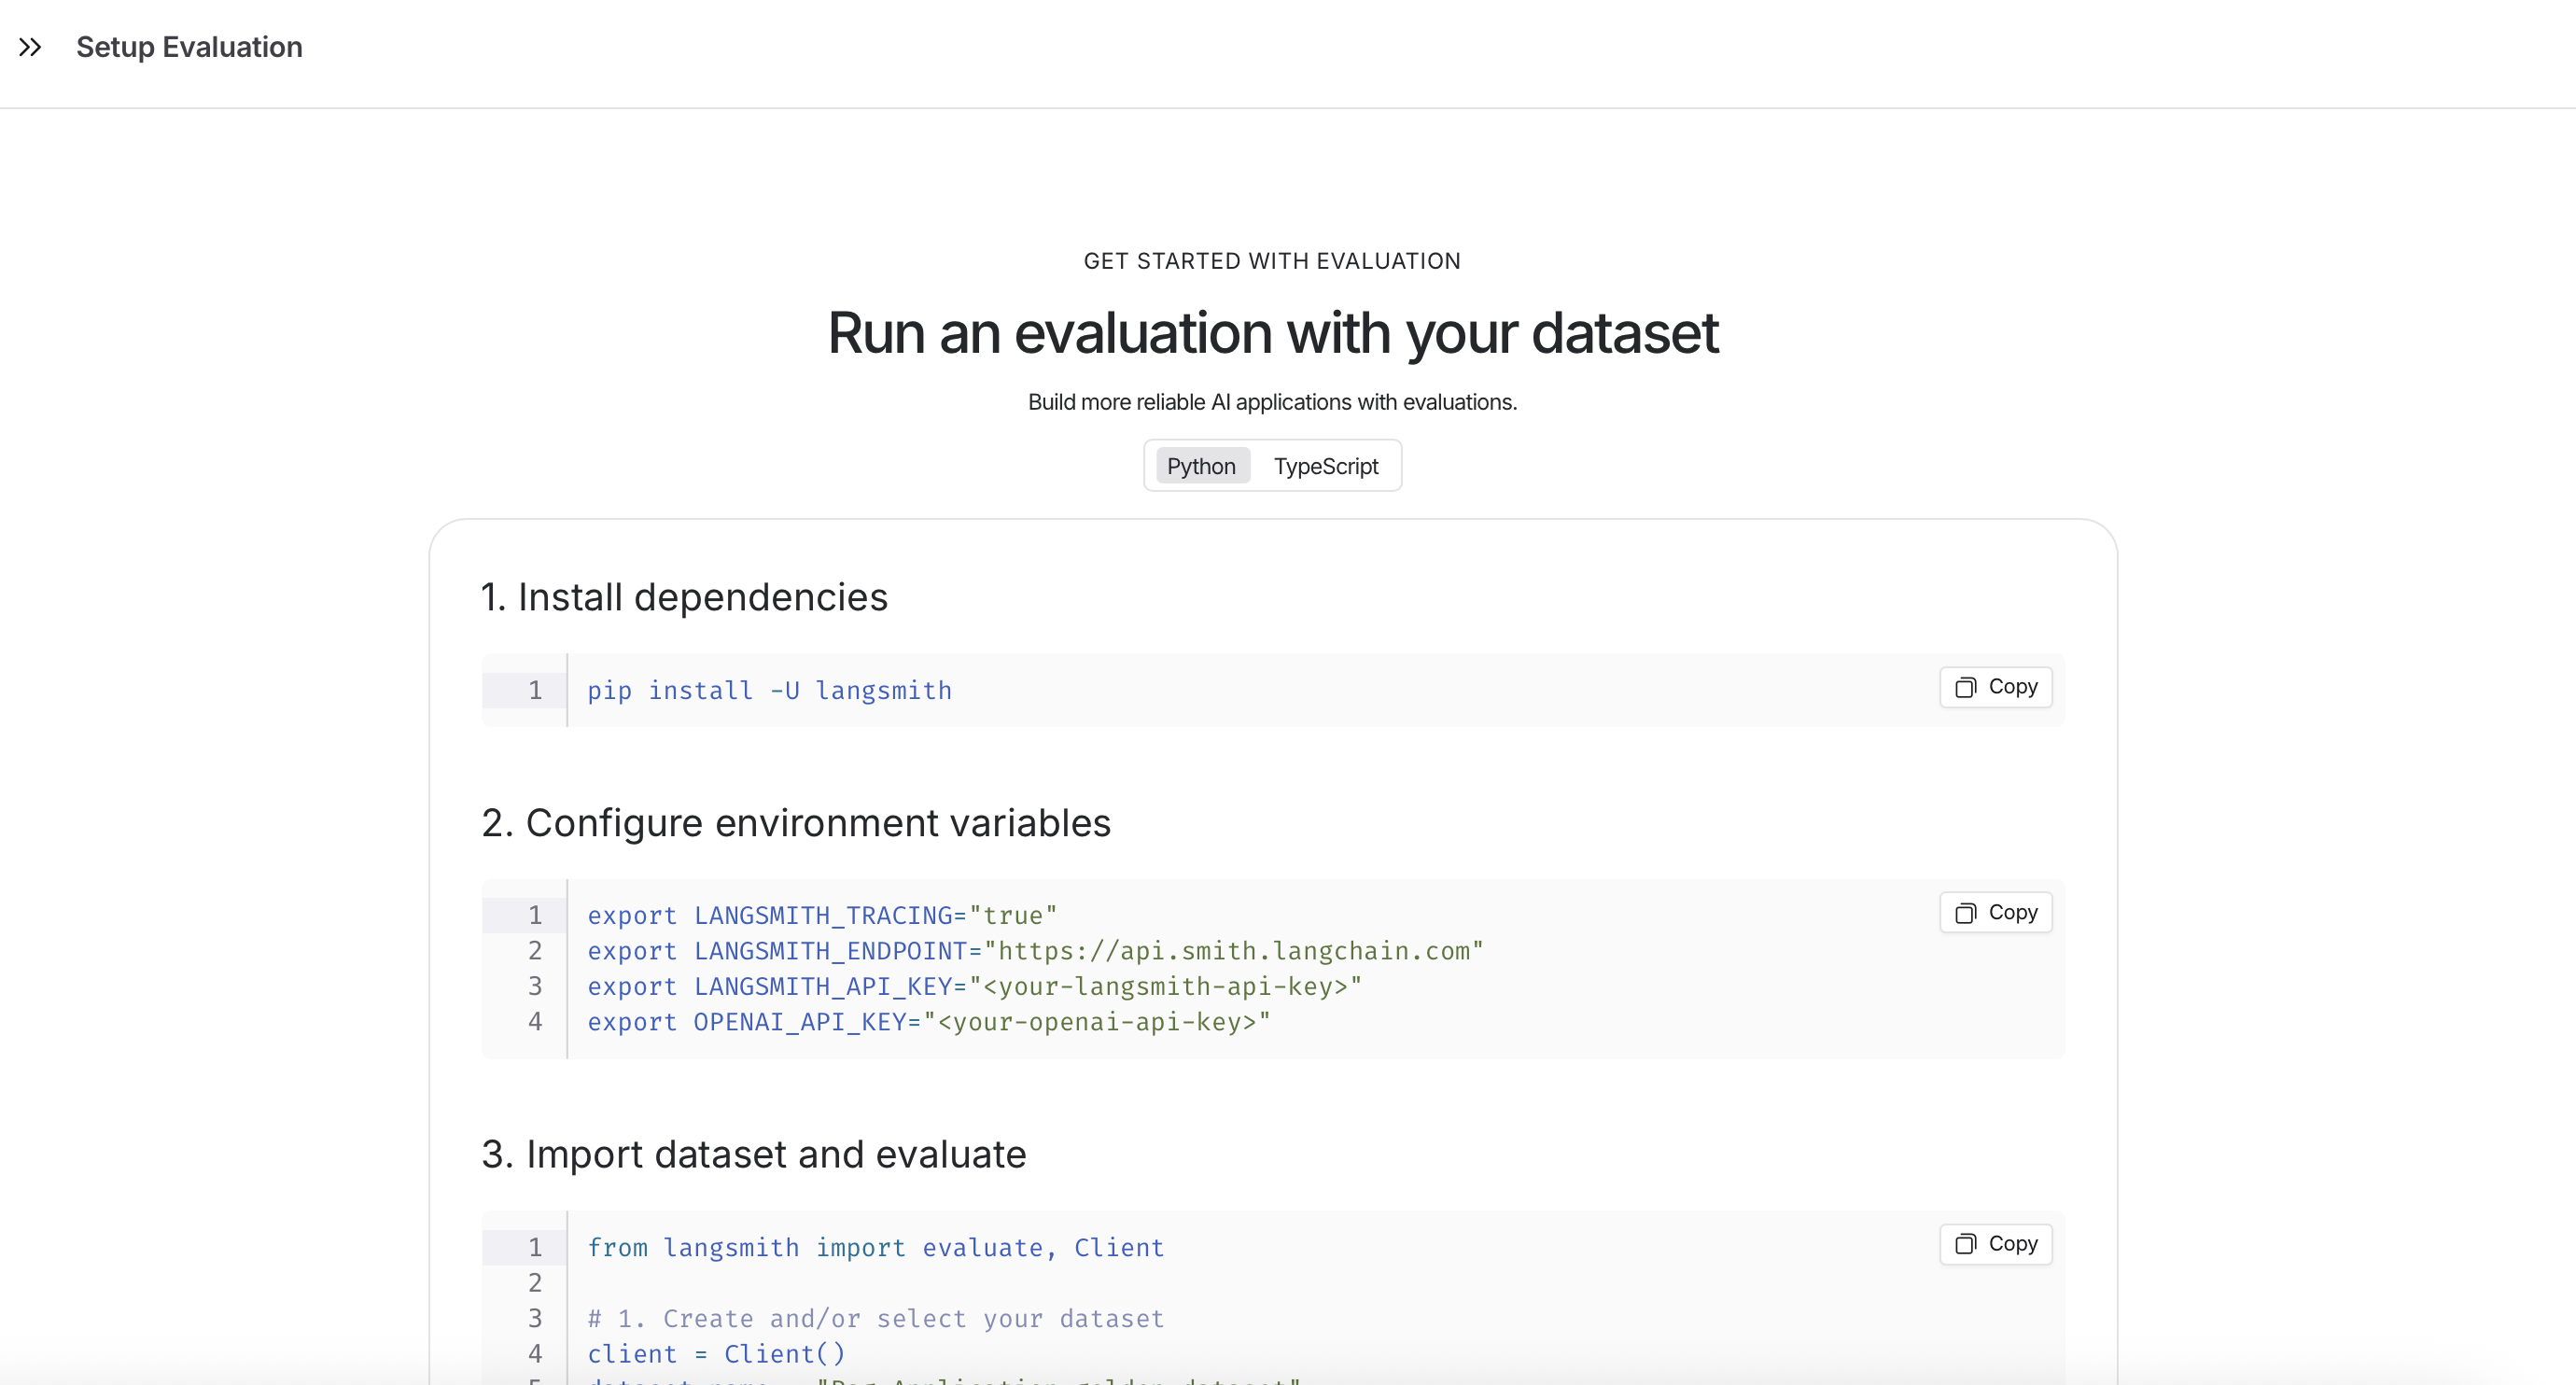

### Setup

In [3]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv( override=True)

True

Here is the RAG Application that we've been working with throughout this course

In [ ]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio

# TODO: Configure this model!
# tried with another model which is cheaper 
MODEL_NAME = "gpt-3.5-turbo"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    # If vector store exists, then load it
    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, index LangSmith documents and create new vector store
    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


### Experiment

Here is a code snippet that should look similar to what you see from the starter code!

There are a few important components here.

1. We have defined an Evaluator
2. We pipe our dataset examples (dict) to the shape of input that our function `langsmith_rag` takes (str) using a target function

In [8]:
from langsmith import evaluate, Client

client = Client()
dataset_name = "Rag Application golden dataset"

def is_concise_enough(reference_outputs: dict, outputs: dict) -> dict:
    score = len(outputs["output"]) < 1.5 * len(reference_outputs["output"])
    return {"key": "is_concise", "score": int(score)}

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-4o"
)

View the evaluation results for experiment: 'gpt-4o-ec35df6e' at:
https://smith.langchain.com/o/465a9d30-549e-4569-b4d2-cbcdcb51b2d9/datasets/ac3e154e-8673-4058-86e3-ff7fd645f13f/compare?selectedSessions=e58382ab-20e2-4098-a6f3-5bbd6cd50808




15it [00:32,  2.20s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I create user feedback with the LangSmi...,To create user feedback using the LangSmith SD...,None,To create user feedback with the LangSmith SDK...,1,2.347632,087e2f51-6c58-4d5e-bf45-e319995f510d,169f0ab9-e38c-4f02-b6b9-cbdcd07ec1eb
1,How can I trace with the @traceable decorator?,To trace with the @traceable decorator in Pyth...,None,To trace with the @traceable decorator in Pyth...,1,1.835724,6fbf4351-be71-47fd-b44c-d249479d35b9,cef80ff7-9a2d-40cb-91e1-bc1e9eaf6dd4
2,Does LangSmith support offline evaluation?,LangSmith's documentation primarily focuses on...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.483260,91ddc27d-49b5-4ee0-a34a-307e946b8779,f5733be0-7396-4139-b336-c72a137b232c
3,Is there an API for accessing LangSmith services?,"Yes, there is an API for accessing LangSmith s...",None,"Yes, LangSmith provides a comprehensive API th...",1,1.632169,afbbb9dd-2c0c-447a-90de-4b782282c4e1,66f9e569-eece-4616-981e-03dbc3c121c2
4,How can I monitor performance using LangSmith?,LangSmith allows you to monitor performance by...,None,"To monitor performance using LangSmith, you ca...",1,3.636305,7695a776-007f-481a-9c1e-dc1f2dc938e3,72a9ddc7-21d4-42c1-8de5-459aa96f8e27
5,What benefits does LangSmith provide for devel...,LangSmith provides developers with tools for o...,None,LangSmith provides several benefits for develo...,1,2.967722,6ff0befe-0399-44a4-b27f-ef1cdb0a1052,75e902b7-3b7e-4e8e-b10d-e29f0f6bea89
6,Is there a javascript Langsmith SDK?,"Yes, there is a JavaScript/TypeScript (JS/TS) ...",None,Yes there is a javascript sdk,0,1.268679,f3039450-fc55-4562-9ae6-d8ad2f39bcf7,e9e909f0-5a70-45de-b7f5-87732f623434
7,What is LangSmith used for in three sentences?,LangSmith is a platform designed for building ...,None,LangSmith is a platform designed for the devel...,1,1.443778,95dd29e6-0545-44a2-804d-b3750ef32e31,402bd778-4d82-41f5-9195-5a27763344b9
8,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,To set up tracing to LangSmith using LangChain...,1,1.997103,636af914-62d7-495d-b3ff-a92e7ee27ad6,39adea67-d6bb-4083-80c6-269583dea203
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.814203,32851741-41c6-4df0-a48a-cdd40869f94d,93443196-90b3-4236-b1a1-e6c08ad6dfeb


### Modifying your Application

Now, let's change our model to gpt-35-turbo and see how it performs!

Make this change, and then run this code snippet!

In [10]:
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-3.5-turbo"
)

View the evaluation results for experiment: 'gpt-3.5-turbo-5cf5a1a8' at:
https://smith.langchain.com/o/465a9d30-549e-4569-b4d2-cbcdcb51b2d9/datasets/ac3e154e-8673-4058-86e3-ff7fd645f13f/compare?selectedSessions=d83bd808-9fe4-4fcb-9c7a-5fe6688046e5




15it [00:27,  1.83s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,1.910456,087e2f51-6c58-4d5e-bf45-e319995f510d,d7765ac3-445c-476d-ba3b-6c2e30155f89
1,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you ne...",None,To trace with the @traceable decorator in Pyth...,1,2.292591,6fbf4351-be71-47fd-b44c-d249479d35b9,eb9fbe22-9299-4aab-a54c-a99903e2ce75
2,Does LangSmith support offline evaluation?,LangSmith allows for online evaluations by pro...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.528315,91ddc27d-49b5-4ee0-a34a-307e946b8779,e853edc8-624e-415b-9658-152bb684be63
3,Is there an API for accessing LangSmith services?,"Yes, there is an API for accessing LangSmith s...",None,"Yes, LangSmith provides a comprehensive API th...",1,1.652654,afbbb9dd-2c0c-447a-90de-4b782282c4e1,44a00cef-5a61-4b51-9a13-496244811fc6
4,How can I monitor performance using LangSmith?,You can monitor performance using LangSmith by...,None,"To monitor performance using LangSmith, you ca...",1,2.045427,7695a776-007f-481a-9c1e-dc1f2dc938e3,0507092b-33f5-4aed-a50b-02cca82ea1a5
5,What benefits does LangSmith provide for devel...,LangSmith provides developers with a platform ...,None,LangSmith provides several benefits for develo...,1,1.642478,6ff0befe-0399-44a4-b27f-ef1cdb0a1052,2fe4f5e3-7ec9-4c48-9536-3a3bbdb65c7f
6,Is there a javascript Langsmith SDK?,"Yes, LangSmith integrates seamlessly with Lang...",None,Yes there is a javascript sdk,0,1.602199,f3039450-fc55-4562-9ae6-d8ad2f39bcf7,78ff1fe8-0030-41e8-bf37-d4dc80711628
7,What is LangSmith used for in three sentences?,LangSmith is a platform designed for building ...,None,LangSmith is a platform designed for the devel...,1,1.357915,95dd29e6-0545-44a2-804d-b3750ef32e31,e6862e90-3b1c-4b8f-a267-e5d8fa9ef72d
8,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith while using Lan...,None,To set up tracing to LangSmith using LangChain...,1,1.939232,636af914-62d7-495d-b3ff-a92e7ee27ad6,4d37d855-bde8-46fd-beba-a1014fd17499
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.808443,32851741-41c6-4df0-a48a-cdd40869f94d,4da04eb4-fa2e-44b1-b835-35372d28fb74


### Running over Different pieces of Data

##### Dataset Version

You can execute an experiment on a specific version of a dataset in the sdk by using the `as_of` parameter in `list_examples`

Let's try running on just our initial dataset.

In [13]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, as_of="initial dataset"),   # We use as_of to specify a version
    evaluators=[is_concise_enough],
    experiment_prefix="initial dataset version"
)

View the evaluation results for experiment: 'initial dataset version-5379a147' at:
https://smith.langchain.com/o/465a9d30-549e-4569-b4d2-cbcdcb51b2d9/datasets/ac3e154e-8673-4058-86e3-ff7fd645f13f/compare?selectedSessions=92492540-0645-4a7b-8dda-71d7848c09b8




15it [00:27,  1.86s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,2.072730,087e2f51-6c58-4d5e-bf45-e319995f510d,85d25568-6835-4a20-94f2-90fdf7fd050b
1,How can I trace with the @traceable decorator?,To trace with the @traceable decorator in Pyth...,None,To trace with the @traceable decorator in Pyth...,1,1.706404,6fbf4351-be71-47fd-b44c-d249479d35b9,31f7b904-6b1c-40d7-9886-bf77e1c538dc
2,Does LangSmith support offline evaluation?,LangSmith primarily supports online evaluation...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.403030,91ddc27d-49b5-4ee0-a34a-307e946b8779,8b9456f1-b457-45ba-ae44-217554660b34
3,Is there an API for accessing LangSmith services?,"Yes, there is an API for accessing LangSmith s...",None,"Yes, LangSmith provides a comprehensive API th...",1,1.420673,afbbb9dd-2c0c-447a-90de-4b782282c4e1,915aa6c9-d38a-4c7f-898c-4fb8f4acec27
4,How can I monitor performance using LangSmith?,You can monitor performance in LangSmith by ru...,None,"To monitor performance using LangSmith, you ca...",1,1.567395,7695a776-007f-481a-9c1e-dc1f2dc938e3,84feaf63-d418-4d7e-93f8-0349dba486ff
5,What benefits does LangSmith provide for devel...,LangSmith is a platform for building productio...,None,LangSmith provides several benefits for develo...,1,2.079125,6ff0befe-0399-44a4-b27f-ef1cdb0a1052,ac595ee6-f053-4596-a683-d939e4357b36
6,Is there a javascript Langsmith SDK?,"Yes, there is a JS/TS (JavaScript/TypeScript) ...",None,Yes there is a javascript sdk,0,2.006907,f3039450-fc55-4562-9ae6-d8ad2f39bcf7,6f1e7f4f-187a-494a-86fb-6d17cf9ff599
7,What is LangSmith used for in three sentences?,LangSmith is a platform designed for building ...,None,LangSmith is a platform designed for the devel...,1,2.095734,95dd29e6-0545-44a2-804d-b3750ef32e31,8d0c1583-6f11-4a8f-a809-b2789ae268ce
8,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith while using Lan...,None,To set up tracing to LangSmith using LangChain...,1,1.740974,636af914-62d7-495d-b3ff-a92e7ee27ad6,139578c4-62e2-4990-997b-af5850128483
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.897952,32851741-41c6-4df0-a48a-cdd40869f94d,bfc0fca0-a40c-460e-ab79-f5029947abc4


##### Dataset Split

You can run an experiment on a specific split of your dataset, let's try running on the Crucial Examples split.

In [15]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, splits=["Crucial examples"]),  # We pass in a list of Splits
    evaluators=[is_concise_enough],
    experiment_prefix="Crucial examples split"
)

View the evaluation results for experiment: 'Crucial examples split-5d821b6b' at:
https://smith.langchain.com/o/465a9d30-549e-4569-b4d2-cbcdcb51b2d9/datasets/ac3e154e-8673-4058-86e3-ff7fd645f13f/compare?selectedSessions=28e2887a-862a-4f41-93cf-2510dbbe7585




4it [00:07,  1.77s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,1.363156,087e2f51-6c58-4d5e-bf45-e319995f510d,6241ff74-a51e-40a4-ae06-7dc1ae88bc6f
1,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you ne...",None,To trace with the @traceable decorator in Pyth...,1,1.832139,6fbf4351-be71-47fd-b44c-d249479d35b9,a49c517f-dc0e-41b1-802d-7ac22a3b6f22
2,Does LangSmith support offline evaluation?,LangSmith supports online evaluations to provi...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.773526,91ddc27d-49b5-4ee0-a34a-307e946b8779,f531a343-b2c8-46b6-b915-81d092d3d1cf
3,Is there an API for accessing LangSmith services?,"Yes, there is an API for accessing LangSmith s...",None,"Yes, LangSmith provides a comprehensive API th...",1,1.605169,afbbb9dd-2c0c-447a-90de-4b782282c4e1,33038477-db07-4b40-a328-228eb738c1c3


##### Specific Data Points

You can specify individual data points to run an experiment over as well

In [17]:
evaluate(
    target_function,
    data=client.list_examples(
        dataset_name=dataset_name, 
        example_ids=[ 
            "afbbb9dd-2c0c-447a-90de-4b782282c4e1",
        ]
    ),
    evaluators=[is_concise_enough],
    experiment_prefix="two specific example ids"
)

View the evaluation results for experiment: 'two specific example ids-120a02e2' at:
https://smith.langchain.com/o/465a9d30-549e-4569-b4d2-cbcdcb51b2d9/datasets/ac3e154e-8673-4058-86e3-ff7fd645f13f/compare?selectedSessions=67a2ca2f-852e-4d5a-8cbc-94ab20d4c27a




1it [00:02,  2.63s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Is there an API for accessing LangSmith services?,"Yes, there is an API for accessing LangSmith s...",None,"Yes, LangSmith provides a comprehensive API th...",1,2.136152,afbbb9dd-2c0c-447a-90de-4b782282c4e1,b005d0f6-8a42-494f-9e78-48210d02e816


### Other Parameters

##### Repetitions

You can run an experiment several times to make sure you have consistent results

In [16]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="two repetitions",
    num_repetitions=2   # This field defaults to 1
)

View the evaluation results for experiment: 'two repetitions-ce78c98e' at:
https://smith.langchain.com/o/465a9d30-549e-4569-b4d2-cbcdcb51b2d9/datasets/ac3e154e-8673-4058-86e3-ff7fd645f13f/compare?selectedSessions=6d57fc0e-1be6-4f13-8cab-6843c0d2ebbd




30it [00:53,  1.79s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,1.791835,087e2f51-6c58-4d5e-bf45-e319995f510d,d65e1a60-7172-4de6-80f5-9ec0ed1fc8c2
1,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you ne...",None,To trace with the @traceable decorator in Pyth...,1,1.791498,6fbf4351-be71-47fd-b44c-d249479d35b9,4a03deda-4bfa-4ed3-b11a-95ff65638210
2,Does LangSmith support offline evaluation?,LangSmith primarily supports online evaluation...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.568443,91ddc27d-49b5-4ee0-a34a-307e946b8779,6ae72ac3-bdf6-454a-887c-1bb8b44abb86
3,Is there an API for accessing LangSmith services?,"Yes, there is an API available for accessing L...",None,"Yes, LangSmith provides a comprehensive API th...",1,1.252208,afbbb9dd-2c0c-447a-90de-4b782282c4e1,735cdd5f-3370-4ce3-b29b-f69dfdee2406
4,How can I monitor performance using LangSmith?,You can monitor performance in LangSmith by ru...,None,"To monitor performance using LangSmith, you ca...",1,1.615052,7695a776-007f-481a-9c1e-dc1f2dc938e3,58ca029c-ed9c-4542-a238-9731e043d54c
5,What benefits does LangSmith provide for devel...,LangSmith provides developers with the ability...,None,LangSmith provides several benefits for develo...,1,1.748976,6ff0befe-0399-44a4-b27f-ef1cdb0a1052,2f6e1f60-a48b-4ac8-b03f-3195b3eabc4d
6,Is there a javascript Langsmith SDK?,"Yes, LangSmith has a JS/TS SDK according to th...",None,Yes there is a javascript sdk,0,1.737339,f3039450-fc55-4562-9ae6-d8ad2f39bcf7,ddd0fad5-6cf0-4937-87e2-15bd9e04c00e
7,What is LangSmith used for in three sentences?,LangSmith is a platform designed for building ...,None,LangSmith is a platform designed for the devel...,1,1.696375,95dd29e6-0545-44a2-804d-b3750ef32e31,d05e8d91-58cd-405f-96ad-644a6cc2a911
8,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith when using Lang...,None,To set up tracing to LangSmith using LangChain...,1,1.570171,636af914-62d7-495d-b3ff-a92e7ee27ad6,555c3443-0e66-4c08-b0b0-8f44e2c027bb
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.688845,32851741-41c6-4df0-a48a-cdd40869f94d,ec1b0c1a-e47a-47f6-9619-2bb19ac340c0


##### Concurrency
You can also kick off concurrent threads of execution to make your experiments finish faster!

In [18]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="concurrency",
    max_concurrency=3,  # This defaults to None, so this is an improvement!
)

View the evaluation results for experiment: 'concurrency-b2151bfc' at:
https://smith.langchain.com/o/465a9d30-549e-4569-b4d2-cbcdcb51b2d9/datasets/ac3e154e-8673-4058-86e3-ff7fd645f13f/compare?selectedSessions=63735045-e828-402f-8841-4f7c6d5e35cc




15it [00:09,  1.61it/s]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Does LangSmith support offline evaluation?,LangSmith primarily supports online evaluation...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.403369,91ddc27d-49b5-4ee0-a34a-307e946b8779,d1cb74e0-16bc-4c6d-bf3d-91932ea93311
1,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,0,1.611797,087e2f51-6c58-4d5e-bf45-e319995f510d,00084741-edbf-40cd-b627-6527bd7382f4
2,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you ne...",None,To trace with the @traceable decorator in Pyth...,1,1.929036,6fbf4351-be71-47fd-b44c-d249479d35b9,30535cd2-5fbd-47f4-8c76-4cbdf5a8c275
3,How can I monitor performance using LangSmith?,You can monitor performance in LangSmith by ru...,None,"To monitor performance using LangSmith, you ca...",1,1.428632,7695a776-007f-481a-9c1e-dc1f2dc938e3,fccba1c9-e9ab-4988-a738-be01b3ff8dd1
4,What benefits does LangSmith provide for devel...,LangSmith provides developers with a platform ...,None,LangSmith provides several benefits for develo...,1,1.686620,6ff0befe-0399-44a4-b27f-ef1cdb0a1052,5395ed10-9809-43d1-91aa-fbf0ab61c654
5,Is there an API for accessing LangSmith services?,"Yes, there is an API for accessing LangSmith s...",None,"Yes, LangSmith provides a comprehensive API th...",1,2.240062,afbbb9dd-2c0c-447a-90de-4b782282c4e1,dd3f2f8a-b1d2-4c45-9ba0-e5b5e537c078
6,Is there a javascript Langsmith SDK?,"Yes, LangSmith offers a JavaScript/TypeScript ...",None,Yes there is a javascript sdk,0,1.303265,f3039450-fc55-4562-9ae6-d8ad2f39bcf7,d67f9a29-b6e7-4f97-98d9-b4bcc8567f20
7,How do I set up tracing to LangSmith if I'm us...,"To set up tracing to LangSmith with LangChain,...",None,To set up tracing to LangSmith using LangChain...,1,1.562035,636af914-62d7-495d-b3ff-a92e7ee27ad6,d5871b69-6287-49d8-866a-5087ea78b750
8,What is LangSmith used for in three sentences?,LangSmith is a platform designed for building ...,None,LangSmith is a platform designed for the devel...,1,1.702800,95dd29e6-0545-44a2-804d-b3750ef32e31,9a05912a-334a-4f0c-b854-bc9e4400782f
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.926181,32851741-41c6-4df0-a48a-cdd40869f94d,1d479d53-ade0-4094-914f-629d44c22daf


##### Metadata 

You can (and should) add metadata to your experiments, to make them easier to find in the UI

In [19]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="metadata added",
    metadata={  # We can pass custom metadata for the experiment, such as the model name
        "model_name": MODEL_NAME
    }
)

View the evaluation results for experiment: 'metadata added-e377736b' at:
https://smith.langchain.com/o/465a9d30-549e-4569-b4d2-cbcdcb51b2d9/datasets/ac3e154e-8673-4058-86e3-ff7fd645f13f/compare?selectedSessions=db6a890e-a51e-4076-a7b8-101371082ebc




15it [00:26,  1.75s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,2.177248,087e2f51-6c58-4d5e-bf45-e319995f510d,d0943aff-0544-4e3e-acb8-651dd43f80c8
1,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you sh...",None,To trace with the @traceable decorator in Pyth...,1,1.418284,6fbf4351-be71-47fd-b44c-d249479d35b9,9b7098c3-7b7d-49d3-8bef-129e7e97eab3
2,Does LangSmith support offline evaluation?,LangSmith primarily supports online evaluation...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.426576,91ddc27d-49b5-4ee0-a34a-307e946b8779,07defa67-8b02-43b6-a5ee-10a058adc499
3,Is there an API for accessing LangSmith services?,"Yes, LangSmith offers an API to access its ser...",None,"Yes, LangSmith provides a comprehensive API th...",1,1.700083,afbbb9dd-2c0c-447a-90de-4b782282c4e1,03849720-6e04-44e4-baba-d892b788dc3f
4,How can I monitor performance using LangSmith?,You can monitor performance in LangSmith by ru...,None,"To monitor performance using LangSmith, you ca...",1,1.385442,7695a776-007f-481a-9c1e-dc1f2dc938e3,bd6eebfd-be2a-46ad-b834-dfa448eea6a3
5,What benefits does LangSmith provide for devel...,LangSmith provides developers with a platform ...,None,LangSmith provides several benefits for develo...,1,1.647034,6ff0befe-0399-44a4-b27f-ef1cdb0a1052,120039e2-a4dd-4d88-9df9-39bb75049f5e
6,Is there a javascript Langsmith SDK?,"Yes, LangSmith provides a JavaScript/TypeScrip...",None,Yes there is a javascript sdk,0,1.461712,f3039450-fc55-4562-9ae6-d8ad2f39bcf7,38b9a401-ce79-40ae-b0e1-838ddd7c4dd4
7,What is LangSmith used for in three sentences?,LangSmith is a platform for building productio...,None,LangSmith is a platform designed for the devel...,1,1.860213,95dd29e6-0545-44a2-804d-b3750ef32e31,295dd808-5b6d-4b62-b41a-6c96155aea78
8,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith when using Lang...,None,To set up tracing to LangSmith using LangChain...,1,2.247095,636af914-62d7-495d-b3ff-a92e7ee27ad6,12bfa45d-4490-48aa-9352-0d4d8a837dd2
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.624815,32851741-41c6-4df0-a48a-cdd40869f94d,393f1018-0bd8-4c29-812f-2d155388b60a


# My langsmith Portal

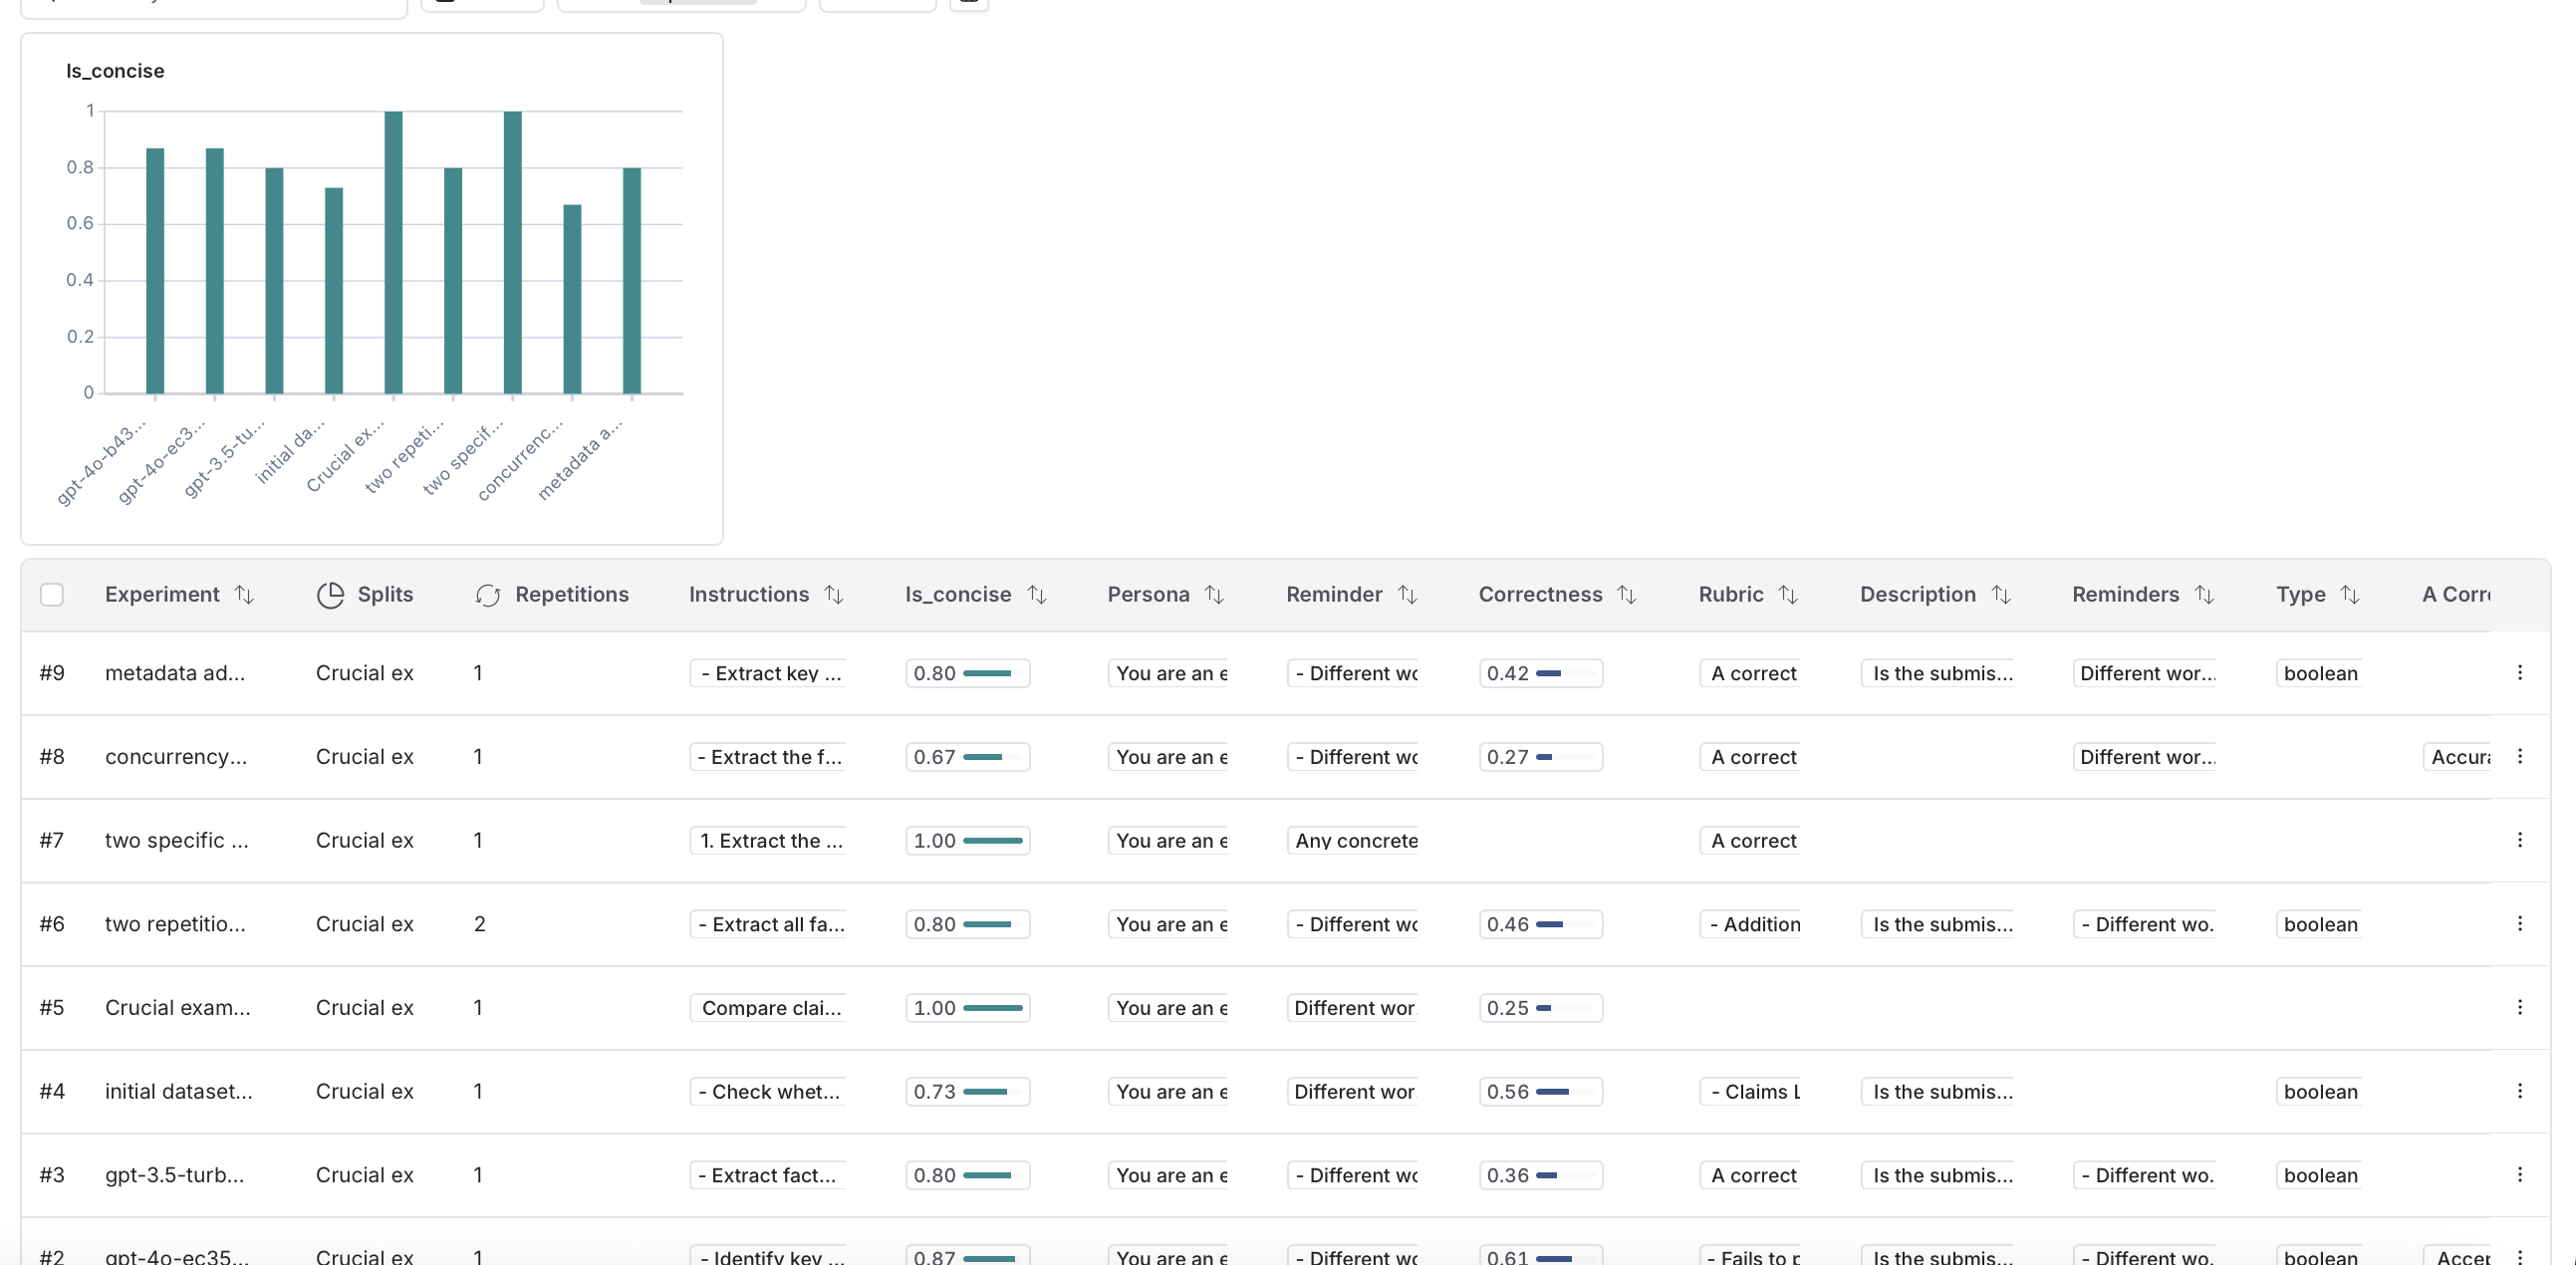

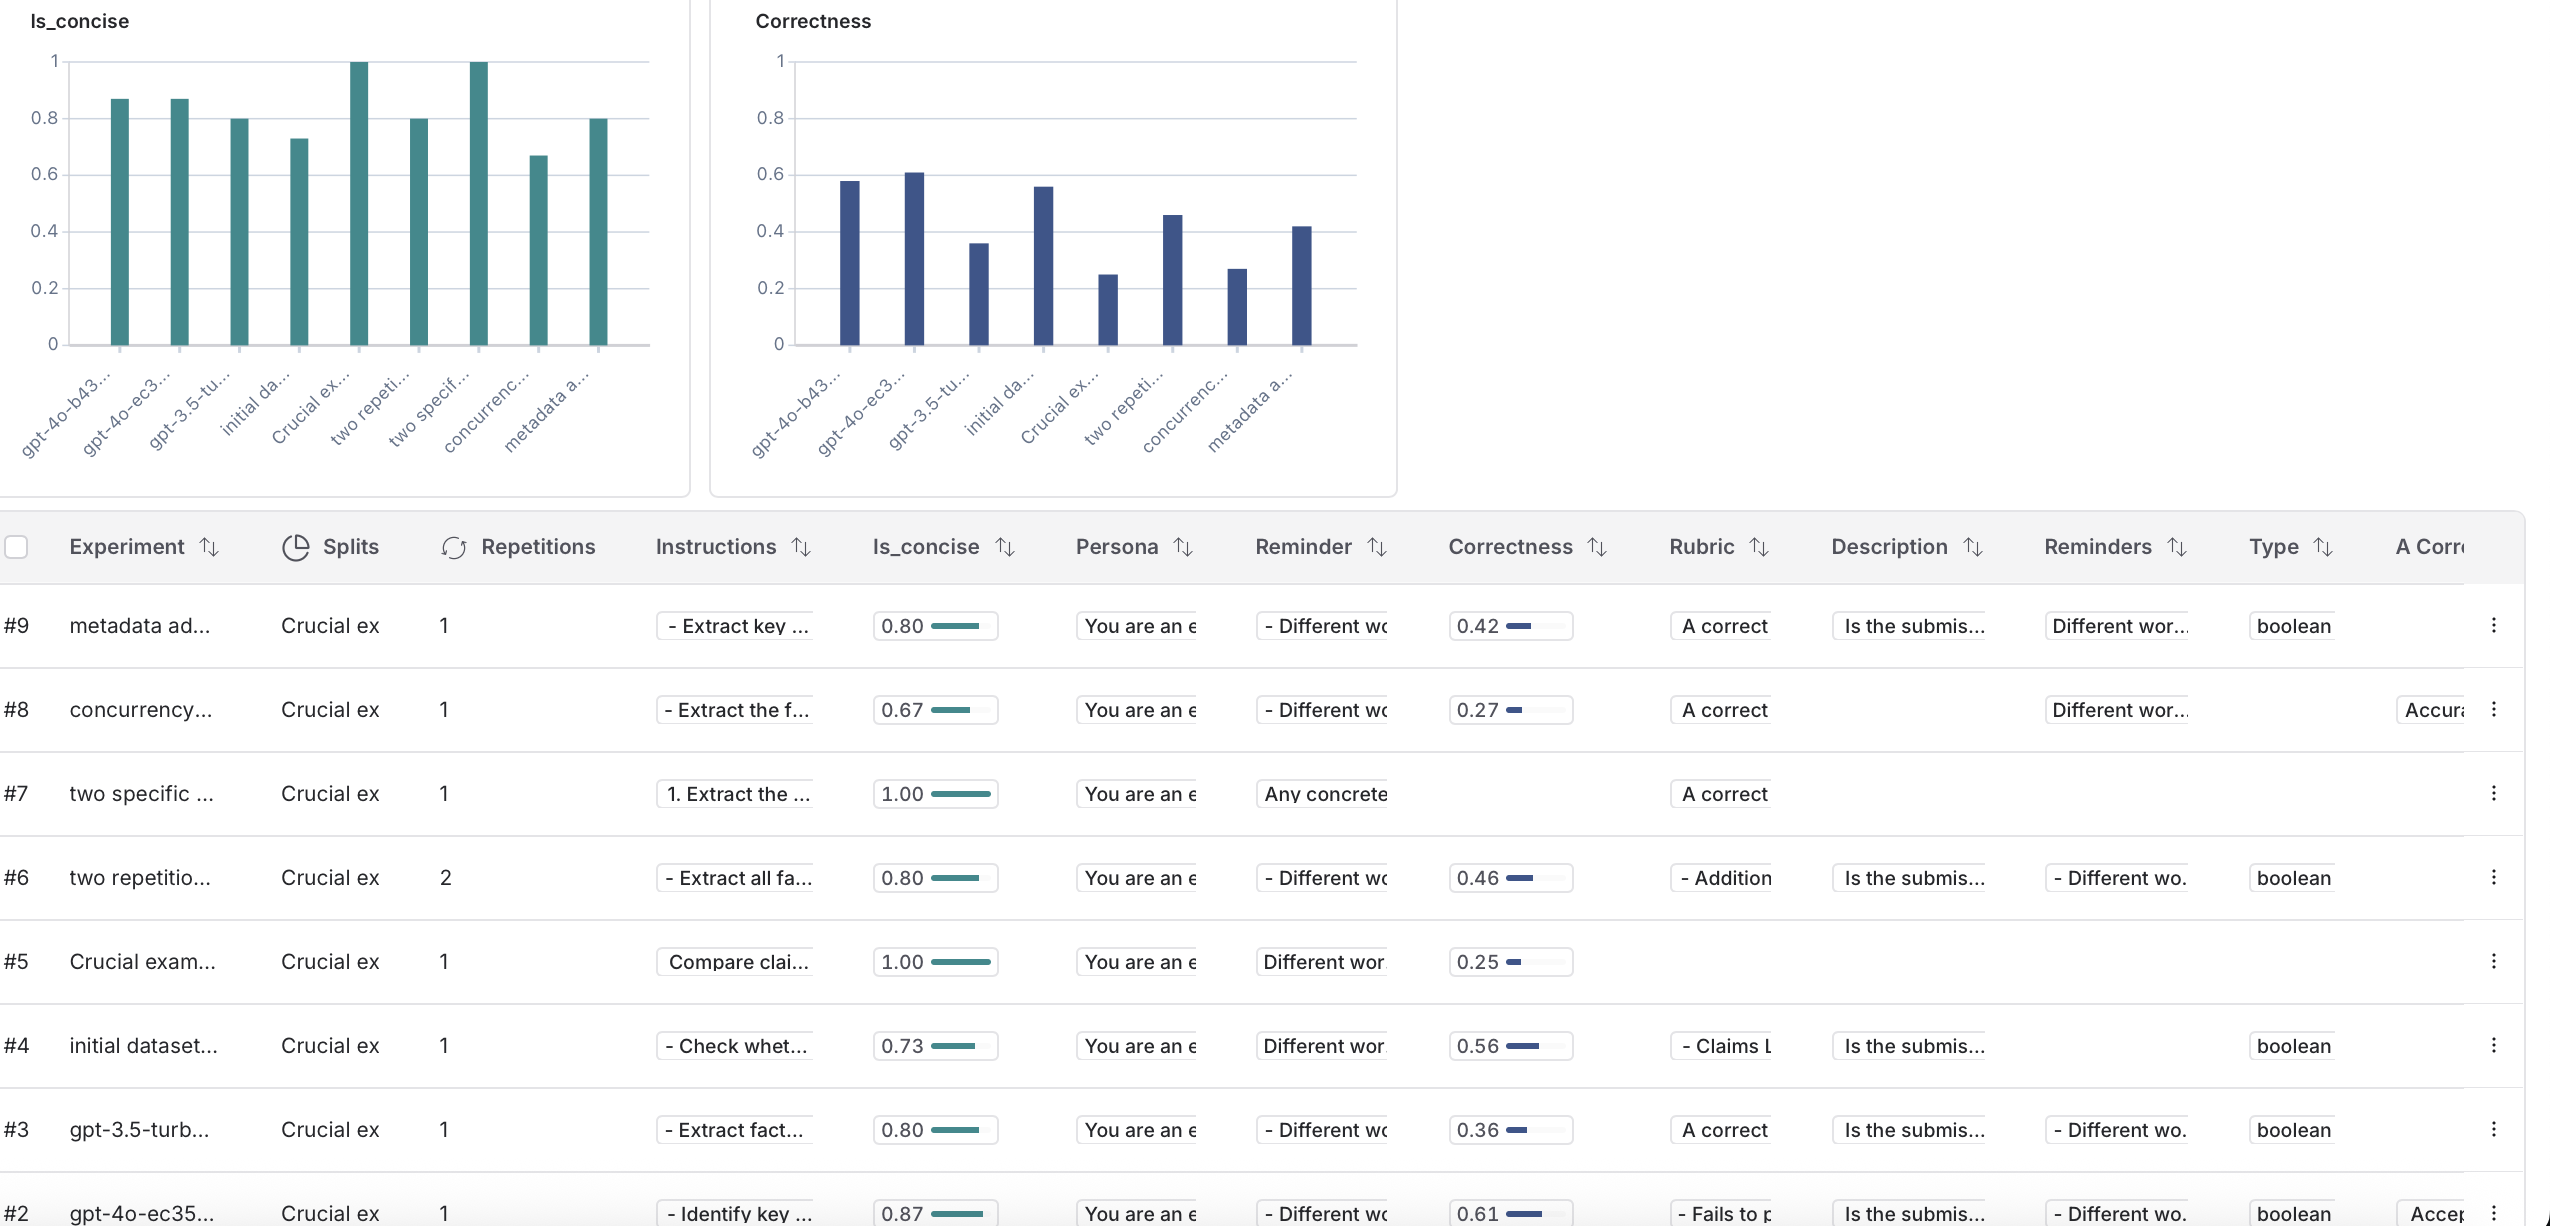